In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import data_retrieval.psql_methods as psql
import pandas as pd
import snob_utils as snob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statistics
img_path  = 'snob_case_study'
feat_path = 'snob_case_study_features'

In [2]:
command = "SELECT * from collection_total_stats"
temp_stats_tuples = psql.execute_commands([command])
columns = ['volume','sales', 'avg_price','num_owners','market_cap','floor','symbol','slug']
stats_df = pd.DataFrame(temp_stats_tuples,columns=columns)

In [7]:
stats_df.sort_values(by='volume',ascending=False,inplace=True)
stats_df.head(20)
#get slugs from top 20 stats_df
slugs = list(stats_df['slug'].head(20).values)
slugs

['boredapeyachtclub',
 'mutant-ape-yacht-club',
 'azuki',
 'otherdeed',
 'art-blocks',
 'clonex',
 'proof-moonbirds',
 'doodles-official',
 'bored-ape-kennel-club',
 'pudgypenguins',
 'meebits',
 'beanzofficial',
 'degods',
 'cool-cats-nft',
 'sandbox',
 'milady',
 'rarible',
 'ens',
 '0n1-force',
 'world-of-women-nft']

In [4]:
df = snob.create_master_snob_df()

Dataset ReturnIndexDataset
    Number of datapoints: 373074
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/expanded_images/val


100%|██████████| 1184/1184 [00:02<00:00, 411.96it/s]


Dataset ReturnIndexDataset
    Number of datapoints: 846346
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/images/val


100%|██████████| 1265/1265 [00:03<00:00, 409.25it/s]


In [15]:
#find out how many slugs from list are in amster df as collections
collections = df[df['Collection'].isin(slugs)]
#count unique collections
collection_slugs = list(collections['Collection'].unique())

In [23]:
#Check whether there is significant correlation between sale price and distance for each slug in collection_slugs
valid_slugs = []
for slug in collection_slugs:
    slug_df  = collections[collections['Collection']==slug]
    distance  = slug_df['distance']
    price = slug_df['sale_price']
    rarity = slug_df['rarity_rank']
    correlation_1, p_value_1 = pearsonr(distance, price)
    correlation_2, p_value_2 = pearsonr(rarity, price)
    if p_value_1 < 0.05 or p_value_2 < 0.05:
        print('Rarity',slug,correlation_2, p_value_2)
        print('Distance',slug,correlation_1, p_value_1)
        valid_slugs.append(slug)
valid_tuple = tuple(valid_slugs)


Rarity cool-cats-nft -0.059736070962043364 0.17131496318167755
Distance cool-cats-nft 0.11246587377218356 0.0098392510091859
Rarity proof-moonbirds -0.2296776586945044 1.5704389265927143e-06
Distance proof-moonbirds 0.29641243900741115 3.964478810405878e-10
Rarity beanzofficial -0.1855303764736122 0.00010697046338900099
Distance beanzofficial 0.24392743317006213 2.9438617857540577e-07
Rarity mutant-ape-yacht-club -0.256510560897773 2.016094468436212e-08
Distance mutant-ape-yacht-club -0.05060088560993747 0.2761930544814938
Rarity meebits -0.12570333101321443 0.027647083651857057
Distance meebits 0.09489872725113846 0.09696983375363562
Rarity doodles-official -0.25403087704024674 3.096877276279076e-09
Distance doodles-official 0.33360551785713566 3.230033971335355e-15
Rarity pudgypenguins -0.11538271050716765 0.005089881347500054
Distance pudgypenguins -0.06049686749847332 0.14286862702298575
Rarity azuki -0.19354029040955031 4.644521920144554e-06
Distance azuki 0.031085748988013036 0.4

In [27]:
valid_tuple
command = [f"select * from nfttoimage where slug in {valid_tuple}"]
rows  = psql.execute_commands(command)

In [31]:
# Column names for the DataFrame
columns = ['slug', 'token_id', 'url']

# Create a DataFrame from the list of tuples
df_images = pd.DataFrame(rows, columns=columns)
#group by slug and count number of images
df_images.groupby('slug').count()


,token_id,url
slug,,
azuki,10000,10000
beanzofficial,19950,19950
clonex,19512,19512
cool-cats-nft,9965,9965
doodles-official,10000,10000
meebits,20000,20000
mutant-ape-yacht-club,19483,19483
proof-moonbirds,10000,10000
pudgypenguins,8888,8888


In [1]:
import pickle
#dump valid slugs to pickle
# with open('valid_slugs.pkl', 'wb') as f:
#     pickle.dump(valid_tuple, f)
#read valid slugs from pickle
with open('valid_slugs.pkl', 'rb') as f:
    valid_tuple = pickle.load(f)

In [2]:
valid_tuple

('cool-cats-nft',
 'proof-moonbirds',
 'beanzofficial',
 'mutant-ape-yacht-club',
 'meebits',
 'doodles-official',
 'pudgypenguins',
 'azuki',
 'clonex')

After this point create_case_study_images() was called, and then the resulting images had their features exrtacted using feature_extract_notebook

In [4]:
command = f"SELECT slug,token_id,sale_price from cf_sales where slug in {valid_tuple}"
temp_stats_tuples = psql.execute_commands([command])
columns = ['slug','token_id', 'sale_price']
sales_df = pd.DataFrame(temp_stats_tuples,columns=columns)

In [7]:
#take sales df and group by slug and token_id, averaging sale price
avg_sales = sales_df.groupby(['slug','token_id']).mean().reset_index()
avg_sales.sort_values(by=['slug','token_id'],ascending=False,inplace=True)

In [8]:
avg_sales

,slug,token_id,sale_price
95299,pudgypenguins,8887,0.805633
95298,pudgypenguins,8886,9.105373
95297,pudgypenguins,8885,0.690000
95296,pudgypenguins,8884,4.059311
95295,pudgypenguins,8883,1.962500
...,...,...,...
4,azuki,58,15.722500
3,azuki,53,11.226680
2,azuki,52,8.750000
1,azuki,49,5.665000


In [10]:
df = snob.assemble_data_and_features('snob_case_study','snob_case_study_features')
df

Dataset ReturnIndexDataset
    Number of datapoints: 137794
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/snob_case_study/val


,Label,Features,Collection,NFT_num,Contract
0,0,"[0.0013048029504716396, -0.013092035427689552,...",azuki,0,0xed5af388653567af2f388e6224dc7c4b3241c544
1,0,"[0.027294615283608437, -0.04734836518764496, -...",azuki,1,0xed5af388653567af2f388e6224dc7c4b3241c544
2,0,"[0.03676558658480644, -0.018740998581051826, -...",azuki,10,0xed5af388653567af2f388e6224dc7c4b3241c544
3,0,"[-0.004882593639194965, -0.011051790788769722,...",azuki,100,0xed5af388653567af2f388e6224dc7c4b3241c544
4,0,"[-0.016948213800787926, 0.00456386199221015, 0...",azuki,1000,0xed5af388653567af2f388e6224dc7c4b3241c544
...,...,...,...,...,...
137789,9,"[-0.09531647711992264, -0.007036624941974878, ...",pudgypenguins,995,0xbd3531da5cf5857e7cfaa92426877b022e612cf8
137790,9,"[-0.046095795929431915, -0.01598743535578251, ...",pudgypenguins,996,0xbd3531da5cf5857e7cfaa92426877b022e612cf8
137791,9,"[-0.06151833385229111, -0.02195701375603676, -...",pudgypenguins,997,0xbd3531da5cf5857e7cfaa92426877b022e612cf8
137792,9,"[-0.04027863219380379, -0.03682368993759155, -...",pudgypenguins,998,0xbd3531da5cf5857e7cfaa92426877b022e612cf8


In [16]:
snob.get_nft_rarities(df)

28


  0%|          | 0/5000 [00:00<?, ?it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 0


  0%|          | 2/5000 [00:00<16:09,  5.16it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1
0x1a92f7381b9f03921564a437210bb9396471050c 10


  0%|          | 4/5000 [00:00<14:57,  5.57it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 100
0x1a92f7381b9f03921564a437210bb9396471050c 1000


  0%|          | 6/5000 [00:01<14:48,  5.62it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1001
0x1a92f7381b9f03921564a437210bb9396471050c 1002


  0%|          | 8/5000 [00:01<15:27,  5.38it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1003
0x1a92f7381b9f03921564a437210bb9396471050c 1004


  0%|          | 10/5000 [00:02<18:52,  4.40it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1005
0x1a92f7381b9f03921564a437210bb9396471050c 1006


  0%|          | 12/5000 [00:02<17:29,  4.75it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1007
0x1a92f7381b9f03921564a437210bb9396471050c 1008


  0%|          | 14/5000 [00:02<17:19,  4.80it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1009
0x1a92f7381b9f03921564a437210bb9396471050c 101


  0%|          | 15/5000 [00:03<18:21,  4.53it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1010


  0%|          | 17/5000 [00:03<17:01,  4.88it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1011
0x1a92f7381b9f03921564a437210bb9396471050c 1012


  0%|          | 18/5000 [00:03<15:56,  5.21it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1013


  0%|          | 20/5000 [00:04<17:40,  4.70it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1014
0x1a92f7381b9f03921564a437210bb9396471050c 1015


  0%|          | 22/5000 [00:04<16:54,  4.91it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1016
0x1a92f7381b9f03921564a437210bb9396471050c 1017


  0%|          | 23/5000 [00:04<16:13,  5.11it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1018


  0%|          | 25/5000 [00:05<16:18,  5.09it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1019
0x1a92f7381b9f03921564a437210bb9396471050c 102


  1%|          | 27/5000 [00:05<16:46,  4.94it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1020


  1%|          | 28/5000 [00:05<16:26,  5.04it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1021
0x1a92f7381b9f03921564a437210bb9396471050c 1022


  1%|          | 30/5000 [00:06<15:26,  5.36it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1023
0x1a92f7381b9f03921564a437210bb9396471050c 1024


  1%|          | 31/5000 [00:06<16:28,  5.03it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1025


  1%|          | 32/5000 [00:06<17:02,  4.86it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1026


  1%|          | 34/5000 [00:06<16:42,  4.95it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1027
0x1a92f7381b9f03921564a437210bb9396471050c 1028


  1%|          | 35/5000 [00:07<16:08,  5.13it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1029


  1%|          | 36/5000 [00:07<17:40,  4.68it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 103


  1%|          | 37/5000 [00:07<17:48,  4.65it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1030


  1%|          | 39/5000 [00:08<18:27,  4.48it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1031
0x1a92f7381b9f03921564a437210bb9396471050c 1032


  1%|          | 41/5000 [00:08<17:44,  4.66it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1033
0x1a92f7381b9f03921564a437210bb9396471050c 1034


  1%|          | 42/5000 [00:08<17:22,  4.76it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1035


  1%|          | 44/5000 [00:09<17:25,  4.74it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1036
0x1a92f7381b9f03921564a437210bb9396471050c 1037


  1%|          | 46/5000 [00:09<16:20,  5.05it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1038
0x1a92f7381b9f03921564a437210bb9396471050c 1039


  1%|          | 47/5000 [00:09<16:22,  5.04it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 104


  1%|          | 49/5000 [00:10<15:36,  5.28it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1040
0x1a92f7381b9f03921564a437210bb9396471050c 1041


  1%|          | 51/5000 [00:10<15:41,  5.26it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1042
0x1a92f7381b9f03921564a437210bb9396471050c 1043


  1%|          | 53/5000 [00:10<15:19,  5.38it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1044
0x1a92f7381b9f03921564a437210bb9396471050c 1045


  1%|          | 55/5000 [00:11<15:49,  5.21it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1046
0x1a92f7381b9f03921564a437210bb9396471050c 1047


  1%|          | 57/5000 [00:11<15:31,  5.30it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1048
0x1a92f7381b9f03921564a437210bb9396471050c 1049


  1%|          | 59/5000 [00:12<16:09,  5.10it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 105
0x1a92f7381b9f03921564a437210bb9396471050c 1050


  1%|          | 61/5000 [00:12<14:50,  5.54it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1051
0x1a92f7381b9f03921564a437210bb9396471050c 1052


  1%|▏         | 63/5000 [00:12<14:45,  5.57it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1053
0x1a92f7381b9f03921564a437210bb9396471050c 1054


  1%|▏         | 65/5000 [00:13<15:52,  5.18it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1055
0x1a92f7381b9f03921564a437210bb9396471050c 1056


  1%|▏         | 67/5000 [00:13<15:38,  5.26it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1057
0x1a92f7381b9f03921564a437210bb9396471050c 1058


  1%|▏         | 69/5000 [00:13<16:21,  5.02it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1059
0x1a92f7381b9f03921564a437210bb9396471050c 106


  1%|▏         | 71/5000 [00:14<15:34,  5.27it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1060
0x1a92f7381b9f03921564a437210bb9396471050c 1061


  1%|▏         | 72/5000 [00:14<16:00,  5.13it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1062


  1%|▏         | 74/5000 [00:15<18:30,  4.43it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1063
0x1a92f7381b9f03921564a437210bb9396471050c 1064


  2%|▏         | 76/5000 [00:15<16:34,  4.95it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1065
0x1a92f7381b9f03921564a437210bb9396471050c 1066


  2%|▏         | 78/5000 [00:15<15:45,  5.21it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1067
0x1a92f7381b9f03921564a437210bb9396471050c 1068


  2%|▏         | 80/5000 [00:16<17:32,  4.67it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1069
0x1a92f7381b9f03921564a437210bb9396471050c 107


  2%|▏         | 82/5000 [00:16<16:26,  4.98it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1070
0x1a92f7381b9f03921564a437210bb9396471050c 1071


  2%|▏         | 84/5000 [00:17<15:47,  5.19it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1072
0x1a92f7381b9f03921564a437210bb9396471050c 1073


  2%|▏         | 86/5000 [00:17<16:07,  5.08it/s]

0x1a92f7381b9f03921564a437210bb9396471050c 1074
0x1a92f7381b9f03921564a437210bb9396471050c 1075


  2%|▏         | 86/5000 [00:17<16:46,  4.88it/s]


KeyboardInterrupt: 

In [3]:
df = snob.assemble_data_and_features('snob_case_study','snob_case_study_features')
selected_columns = sorted(df[['Contract', 'NFT_num']].to_numpy().tolist())
command = "Select contract,token_id from nft_to_rarity_2"
rarities = psql.execute_commands([command])
print(len(selected_columns))
selected_columns_trim = [tuple(x) for x in selected_columns]
rarities_set = set(rarities)
l1 = [list(sublist) for sublist in selected_columns_trim if sublist not in rarities_set]
print(len(l1))

Dataset ReturnIndexDataset
    Number of datapoints: 137794
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/snob_case_study/val
137794
17043


In [3]:
df = snob.create_snob_df(img_path,feat_path,case_study=True)


Dataset ReturnIndexDataset
    Number of datapoints: 137794
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/snob_case_study/val
slug           object
token_id        int64
sale_price    float64
dtype: object


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


In [4]:
df = snob.add_rarity_ranks_to_df(df)
df

,Contract,NFT_num,rarity_rank,Label,Collection,slug,token_id,sale_price,distance
0,0x1a92f7381b9f03921564a437210bb9396471050c,1016,7170,4,cool-cats-nft,cool-cats-nft,1016,7.875,0.495027
1,0x1a92f7381b9f03921564a437210bb9396471050c,1016,7170,4,cool-cats-nft,cool-cats-nft,1016,7.875,0.495027
2,0x1a92f7381b9f03921564a437210bb9396471050c,1019,2172,4,cool-cats-nft,cool-cats-nft,1019,0.905,0.421756
3,0x1a92f7381b9f03921564a437210bb9396471050c,1019,2172,4,cool-cats-nft,cool-cats-nft,1019,0.905,0.421756
4,0x1a92f7381b9f03921564a437210bb9396471050c,1032,2317,4,cool-cats-nft,cool-cats-nft,1032,0.215,0.434993
...,...,...,...,...,...,...,...,...,...
104294,0xed5af388653567af2f388e6224dc7c4b3241c544,9994,6688,0,azuki,azuki,9994,8.300,0.605202
104295,0xed5af388653567af2f388e6224dc7c4b3241c544,9995,6889,0,azuki,azuki,9995,6.990,0.648816
104296,0xed5af388653567af2f388e6224dc7c4b3241c544,9996,2025,0,azuki,azuki,9996,6.200,0.746281
104297,0xed5af388653567af2f388e6224dc7c4b3241c544,9998,1719,0,azuki,azuki,9998,21.500,0.671391


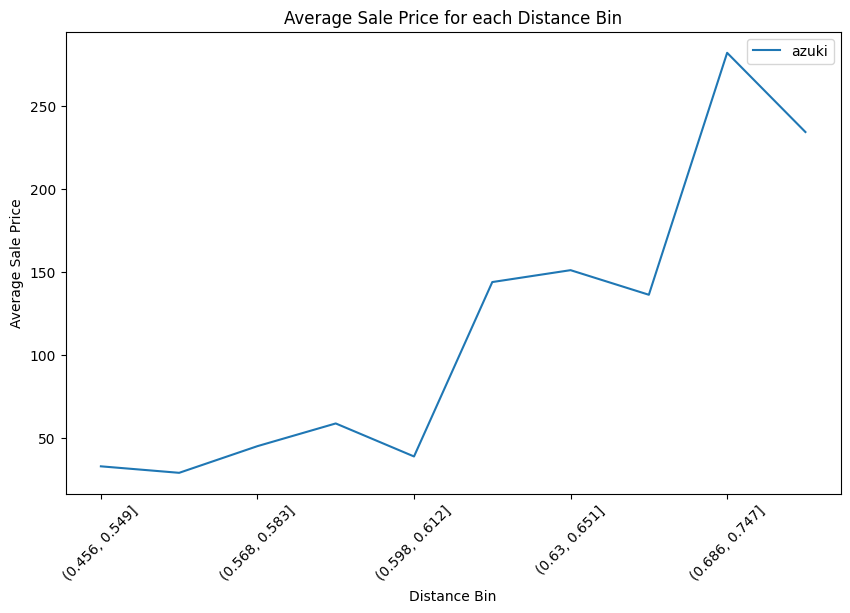

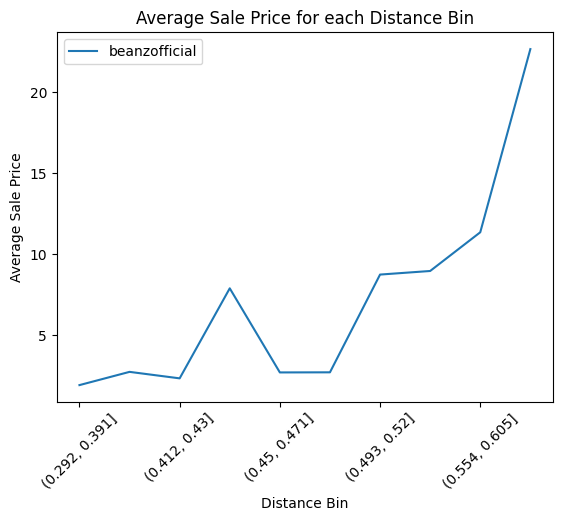

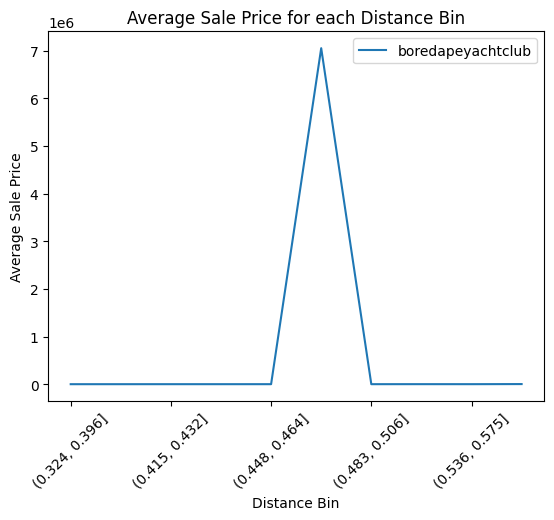

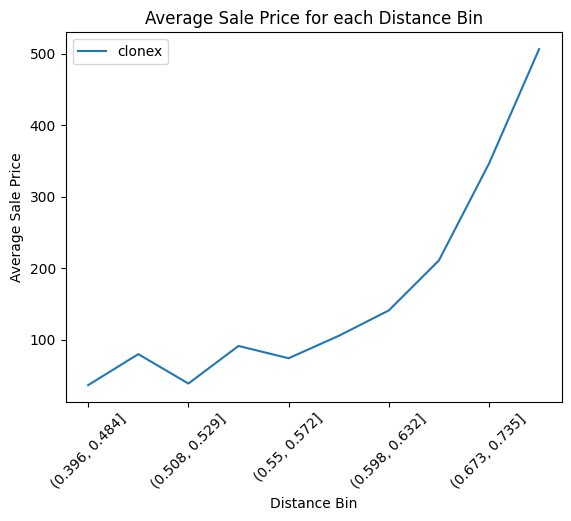

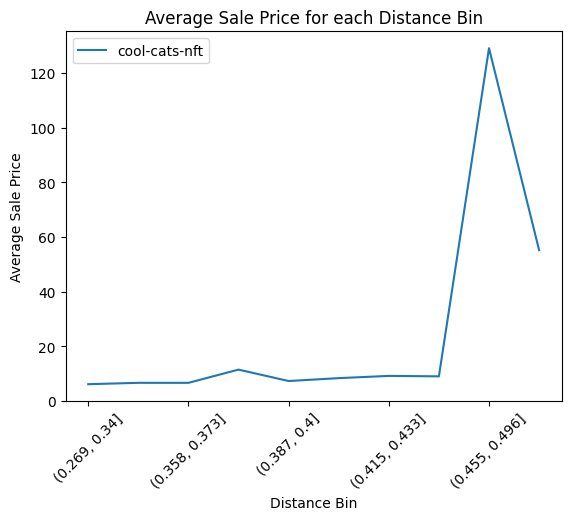

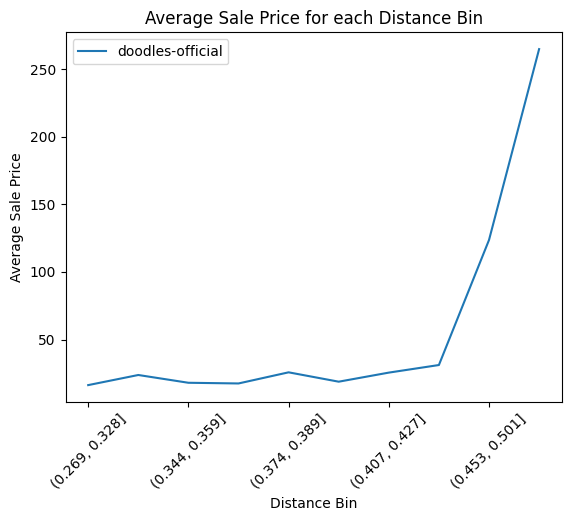

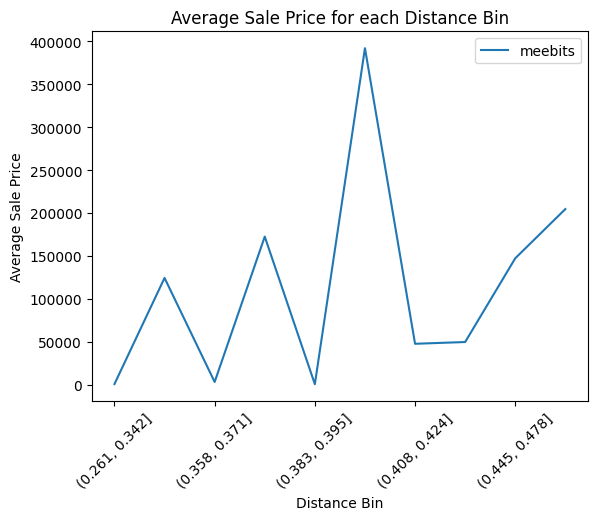

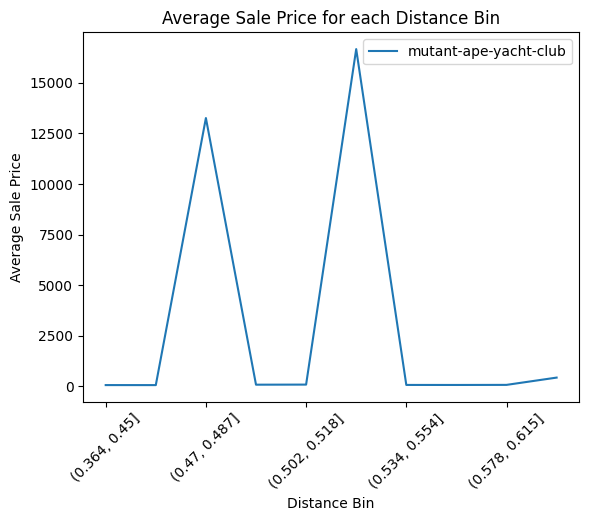

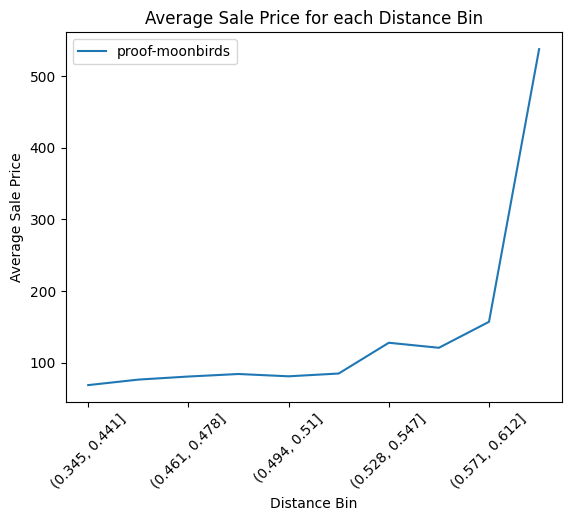

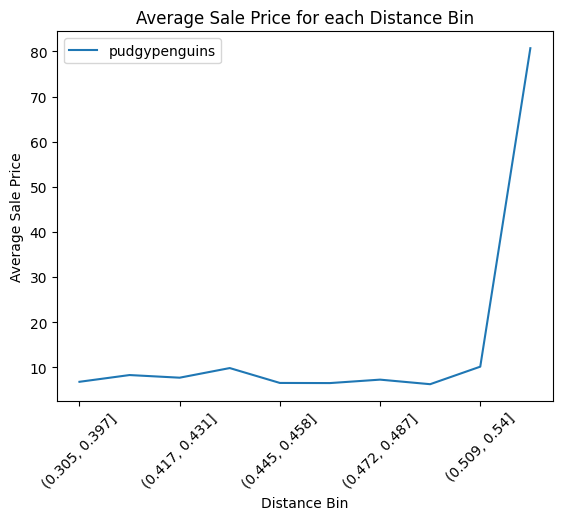

In [23]:
#group by colleciton
df_grouped = df.groupby('Collection')
plt.figure(figsize=(10, 6))
for name, group in df_grouped:
    group['distance_bin'] = pd.qcut(group['distance'], 10)

    # Group by the bins and calculate the average 'saleprice' in each bin
    average_sale_price_in_bins = group.groupby('distance_bin')['sale_price'].var()
    # Plot the average sale prices
    
    average_sale_price_in_bins.plot(kind='line',label=name)
    plt.xlabel('Distance Bin')
    plt.ylabel('Average Sale Price')
    # plt.yscale('log')
    plt.title('Average Sale Price for each Distance Bin')
    plt.xticks(rotation=45)
    # plt.ylim(0, 10)
    plt.legend()
    plt.show()




In [28]:
df['Collection'].unique()

array(['cool-cats-nft', 'proof-moonbirds', 'beanzofficial',
       'mutant-ape-yacht-club', 'meebits', 'doodles-official',
       'boredapeyachtclub', 'pudgypenguins', 'azuki', 'clonex'],
      dtype=object)

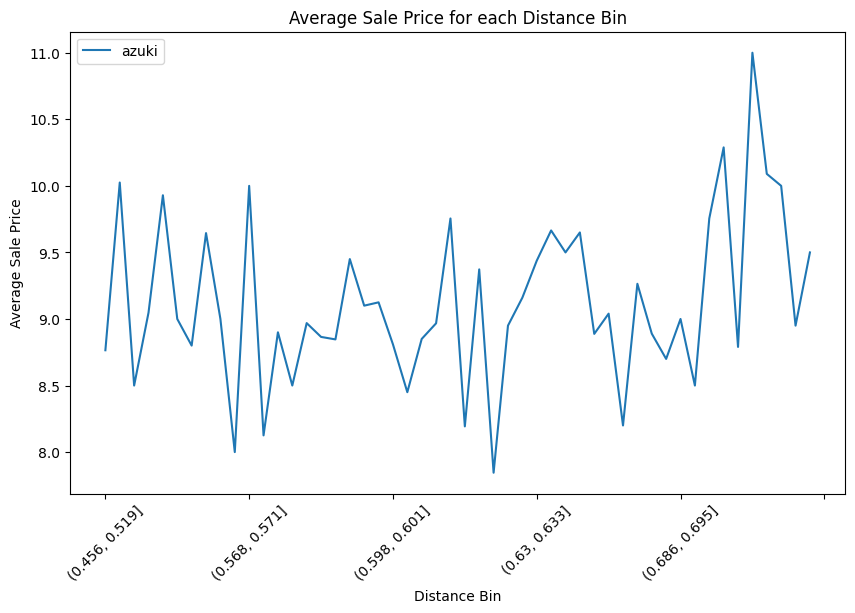

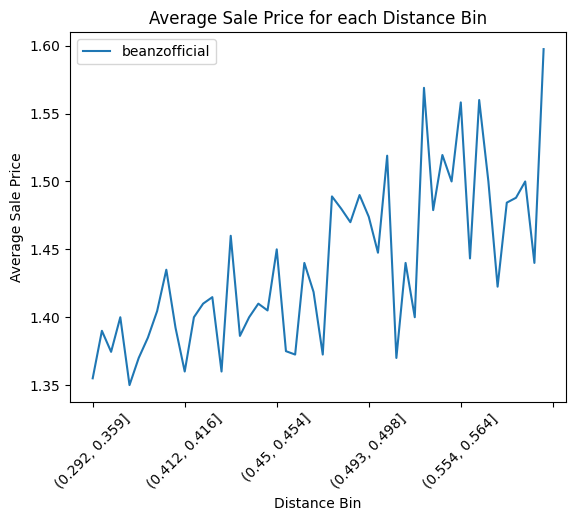

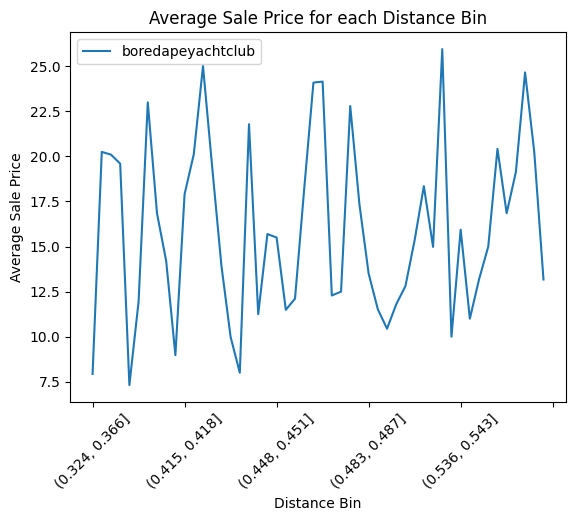

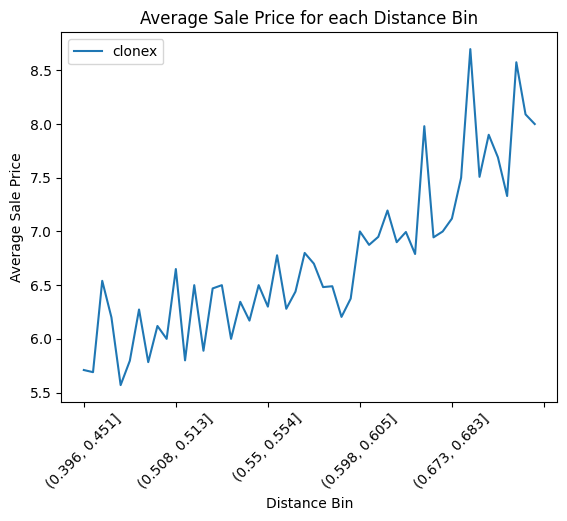

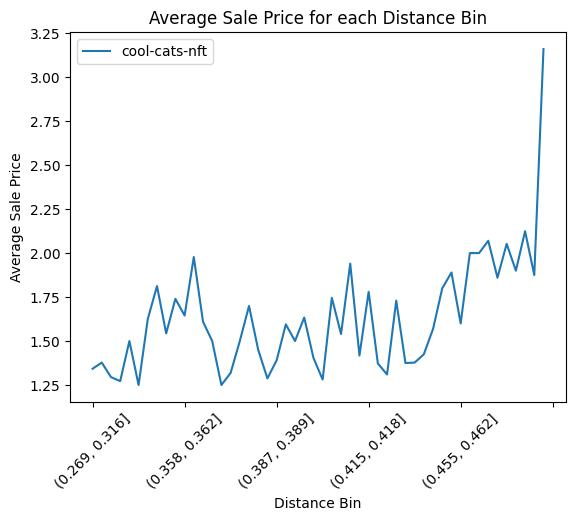

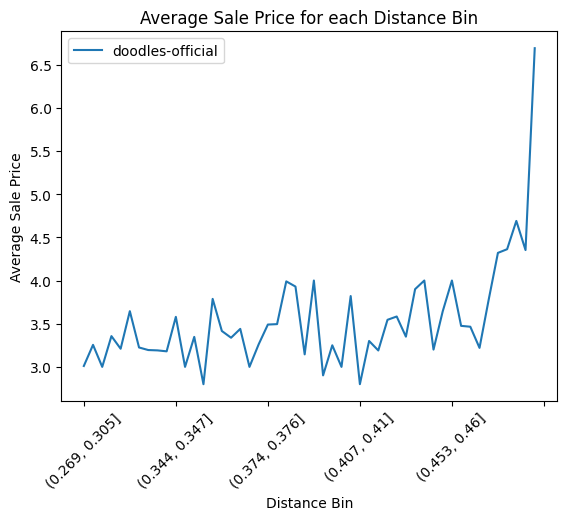

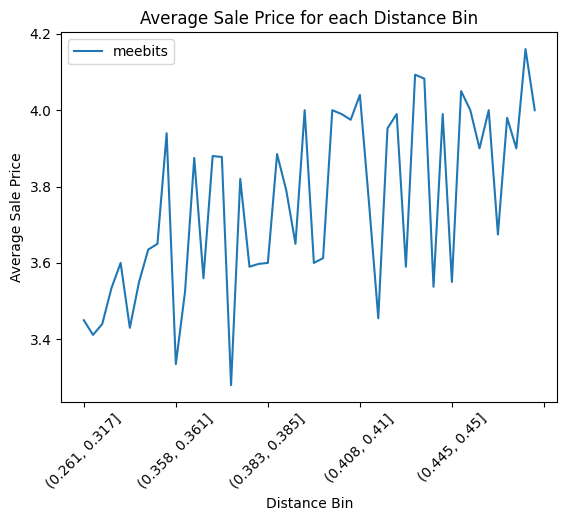

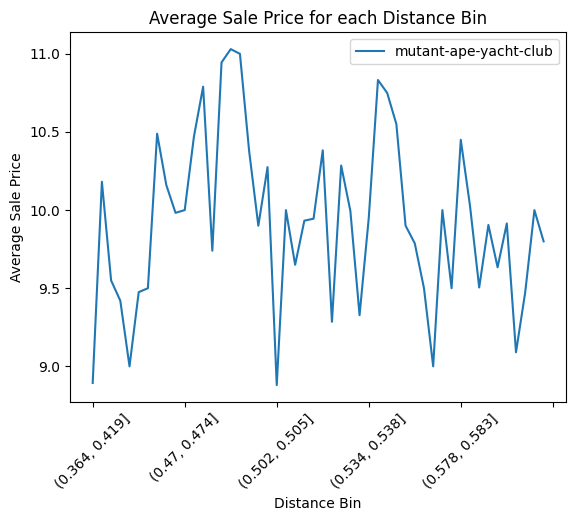

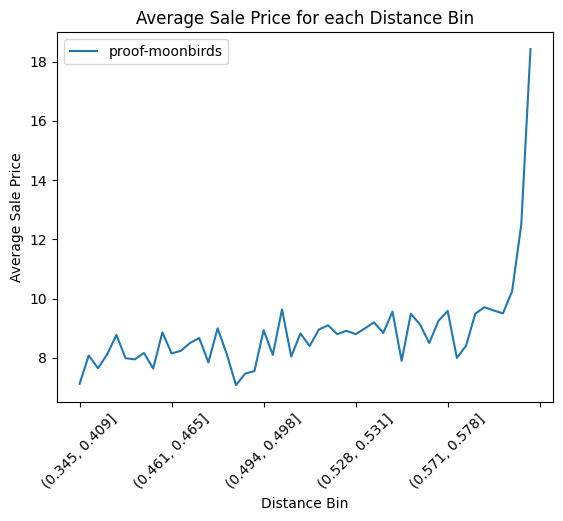

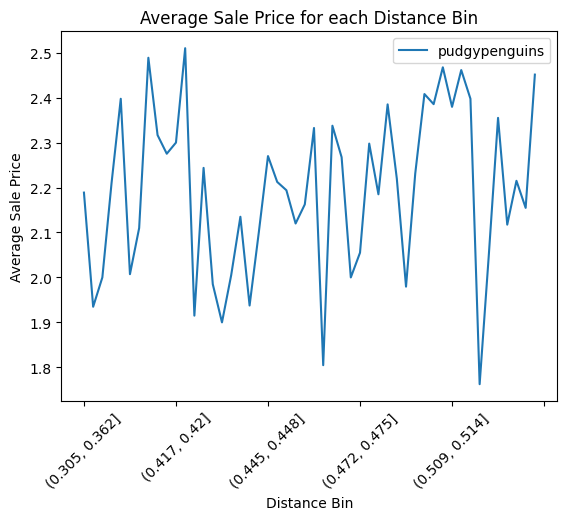

In [19]:
#group by colleciton
df_grouped = df.groupby('Collection')
plt.figure(figsize=(10, 6))
for name, group in df_grouped:
    group['distance_bin'] = pd.qcut(group['distance'], 50)
    # group = group.query("rarity_rank < 1000")
    # Group by the bins and calculate the average 'saleprice' in each bin
    average_sale_price_in_bins = group.groupby('distance_bin')['sale_price'].median()
    # Plot the average sale prices
    
    average_sale_price_in_bins.plot(kind='line',label=name)
    plt.xlabel('Distance Bin')
    plt.ylabel('Average Sale Price')
    plt.title('Average Sale Price for each Distance Bin')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()